In [1]:
import tqdm
import pickle
import numpy as np
import tensorflow as tf
import scipy
import sklearn
import sklearn.datasets
import sklearn.covariance
import sklearn.preprocessing
import pandas as pd
import plotly
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('ticks')
# seaborn.set(style='ticks', font='TakaoGothic')
matplotlib.rcParams['pdf.fonttype'] = 42
plotly.offline.init_notebook_mode(connected=True)
palette = sns.color_palette("RdBu_r", n_colors=25)
% matplotlib inline

import knn

/home/ytakashina/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
target = (np.arange(4000) < 3000).astype(int)
X1 = scipy.stats.multivariate_normal(mean=[+8, 0], cov=np.eye(2)).rvs(1000)
X2 = scipy.stats.multivariate_normal(mean=[-8, 0], cov=np.eye(2)).rvs(1000)
X3 = scipy.stats.multivariate_normal(mean=[0, +8], cov=np.eye(2)).rvs(1000)
X4 = scipy.stats.multivariate_normal(mean=[0, -8], cov=np.eye(2)).rvs(1000)
features = sklearn.preprocessing.scale(np.vstack([X1, X2, X3, X4]))
features.shape

(4000, 2)

In [3]:
d_c = 2
k = 2
n = 4000
lamb = 0.0
np.random.seed(1)

In [4]:
alpha = tf.Variable(np.zeros(d_c), dtype=tf.float32)
beta_ = tf.Variable(np.random.gamma(1, size=[d_c, d_c]), dtype=tf.float32)
beta_triu = tf.matrix_band_part(beta_, 0, -1)
beta_diag = tf.matrix_band_part(beta_, 0, 0)
beta = beta_triu + tf.transpose(beta_triu) - beta_diag
rho = tf.Variable(np.random.normal(size=[d_c, k]), dtype=tf.float32)
phi = tf.Variable(np.random.normal(size=[k]), dtype=tf.float32)

In [5]:
x = tf.placeholder(tf.float32, [n, d_c])
y = tf.placeholder(tf.int32, [n])

In [6]:
beta_diag = tf.diag_part(beta)                    # [d_c]
rho_y = tf.gather(rho, y, axis=1)                 # [d_c, n]
beta_x = tf.matmul(beta, tf.transpose(x))         # [d_c, n]
dev = tf.reshape(alpha, [-1, 1]) + rho_y - beta_x # [d_c, n]
loss = -0.5 * n * tf.reduce_sum(tf.log(beta_diag))
loss += tf.reduce_sum(dev * dev / tf.reshape(beta_diag, [-1, 1]) / 2)

In [7]:
rho_x = tf.matmul(x, rho)                 # [n, k]
logits = rho_x + tf.reshape(phi, [1, -1]) # [n, k]
p_k = tf.nn.softmax(logits)               # [n, k]
y_onehot = tf.one_hot(y, k)               # [n, k]
loss += -tf.reduce_sum(tf.log(tf.reduce_sum(p_k * y_onehot, axis=1)))

In [8]:
regularizer = tf.contrib.layers.l1_regularizer(scale=lamb)
weights_list = [beta_triu - beta_diag, np.sqrt(2/3) * tf.norm(rho, axis=1)]
loss += tf.contrib.layers.apply_regularization(regularizer, weights_list)

INFO:tensorflow:Scale of 0 disables regularizer.


In [9]:
optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
display_epoch = 1000
training_epochs = 10000
for epoch in range(training_epochs):
    _, l = sess.run([optimizer, loss], {x: features, y: target})

    if (epoch+1) % display_epoch == 0:
        print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(l))

    if np.isnan(l):
        print('loss becomes nan at epoch %d' % epoch)
        break

Epoch: 1000 loss= 2017.703735352
Epoch: 2000 loss= 2017.704589844
Epoch: 3000 loss= 2017.704589844
Epoch: 4000 loss= 2017.704589844
Epoch: 5000 loss= 2017.704589844
Epoch: 6000 loss= 2017.704589844
Epoch: 7000 loss= 2017.704589844
Epoch: 8000 loss= 2017.704589844
Epoch: 9000 loss= 2017.704589844
Epoch: 10000 loss= 2017.704589844


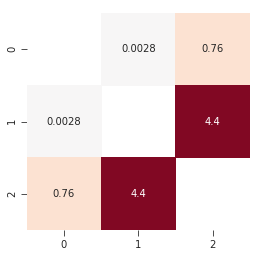

In [12]:
pre_estimate = sess.run(beta)
rho_estimate = sess.run(rho)
adj_cc = pre_estimate
adj_dc = np.linalg.norm(rho_estimate, axis=1)
adj_u = np.hstack((adj_cc, adj_dc.reshape(-1, 1)))
adj_l = np.append(adj_dc, np.nan)
adj = np.vstack((adj_u, adj_l))
adj[np.eye(3, dtype=bool)] = np.nan
plt.figure(figsize=[4, 4])
sns.heatmap(adj, cmap=palette, cbar=False, annot=True, center=0)

In [13]:
df = pd.DataFrame(features)
df['class'] = target

In [14]:
n, d = df.values.shape
edges = knn.learn_mrf(df.values)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj2 = nx.adjacency_matrix(g).toarray().astype(float)
adj2[np.eye(d, dtype=bool)] = np.nan

In [15]:
ground_truth = [[np.nan, 1, 0], [1, np.nan, 1], [0, 1, np.nan]]

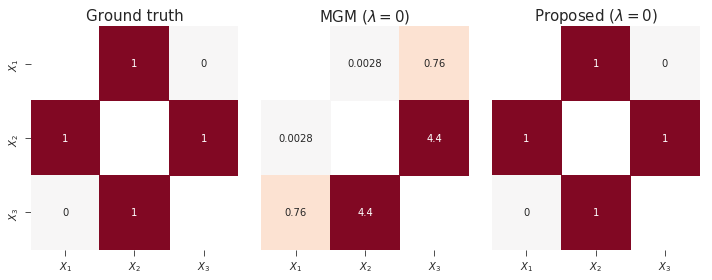

In [16]:
f, axes = plt.subplots(1, 3, figsize=[10, 4])
axes[0].set_title('Ground truth', fontsize=15)
axes[1].set_title('MGM ($\lambda = 0$)', fontsize=15)
axes[2].set_title('Proposed ($\lambda = 0$)', fontsize=15)
labels = ['$X_1$', '$X_2$', '$X_3$']
sns.heatmap(ground_truth, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False, xticklabels=labels, yticklabels=labels)
sns.heatmap(adj, annot=True, center=0, ax=axes[1], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
sns.heatmap(adj2, annot=True, center=0, ax=axes[2], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
plt.tight_layout()
plt.savefig('output/heat-gmm.pdf', format='pdf')